##### ============================================================
##### 🎬 IMDB Movie Reviews Analysis Pipeline (Functional)
##### Tasks:
##### 1) Sentiment Classification (3 classes)
##### 2) Movie Clustering (4-6 categories)
##### 3) Review Summarization (per movie or cluster)
##### ============================================================

In [3]:
 !pip install -q transformers datasets evaluate accelerate peft


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00


In [4]:
# =============================================
# 1) Imports
# =============================================
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding, pipeline, EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model
from sentence_transformers import SentenceTransformer
import evaluate
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
# =============================================
# 2) Sentiment Model Creation
# =============================================
def create_sentiment_model(model_name="distilbert-base-uncased", num_labels=3):
    """
    Create a transformer sentiment classification model with LoRA adapters.
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    model.config.id2label = {0: "NEGATIVE", 1: "POSITIVE", 2: "NEUTRAL"}
    model.config.label2id = {"NEGATIVE": 0, "POSITIVE": 1, "NEUTRAL": 2}

    # LoRA adapters
    lora_config = LoraConfig(
        r=8, lora_alpha=16, lora_dropout=0.1,
        bias="none", task_type="SEQ_CLS",
        target_modules=["q_lin", "k_lin", "v_lin"]
    )
    model = get_peft_model(model, lora_config)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    accuracy_metric = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1")

    return model, tokenizer, data_collator, accuracy_metric, f1_metric


def compute_metrics(eval_pred, accuracy_metric, f1_metric):
    """
    Compute accuracy and F1 during evaluation.
    """
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    }


def train_sentiment(
    model,
    tokenizer,
    data_collator,
    accuracy_metric,
    f1_metric,
    train_dataset,
    eval_dataset,
    output_dir="./results",
    epochs=5
):
    """
    Train the sentiment model on IMDB dataset.
    """
    # Tokenize datasets
    train_enc = train_dataset.map(
        lambda x: tokenizer(x["text"], truncation=True, max_length=256),
        batched=True,
        remove_columns=["text"]
    )
    eval_enc = eval_dataset.map(
        lambda x: tokenizer(x["text"], truncation=True, max_length=256),
        batched=True,
        remove_columns=["text"]
    )
    train_enc.set_format("torch")
    eval_enc.set_format("torch")

    # Training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-4,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=epochs,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=100,
        fp16=True,
        gradient_accumulation_steps=2,
        load_best_model_at_end=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_enc,
        eval_dataset=eval_enc,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=lambda p: compute_metrics(p, accuracy_metric, f1_metric),
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train()
    return trainer, eval_enc


def predict_sentiment(trainer_or_model, tokenizer, texts):
    """
    Run inference for sentiment analysis.
    """
    pipe = pipeline("text-classification",
                    model=trainer_or_model.model if hasattr(trainer_or_model, 'model') else trainer_or_model,
                    tokenizer=tokenizer)
    return pipe(texts)



In [6]:
# =============================================
# 3) Movie Clustering with Transformer Embeddings
# =============================================
def build_text_representation(row):
    """
    Build a text string from movie metadata to be embedded.
    """
    return f"{row['Movie_Title']} | {row['main_genre']} {row['side_genre']} | {row['Director']} | {row['Actors']}"


def prepare_clustering(movies_csv, n_clusters=5):
    """
    Create clustering model using transformer embeddings.
    """
    df = pd.read_csv(movies_csv)

    # Build text representation
    df["text_repr"] = df.apply(build_text_representation, axis=1)

    # Encode with SentenceTransformer
    embedder = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = embedder.encode(df["text_repr"].tolist(), show_progress_bar=True)

    # Cluster embeddings
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df["Cluster"] = kmeans.fit_predict(embeddings)

    return df, embedder, kmeans


def predict_cluster(movie, embedder, kmeans):
    """
    Predict cluster for a new movie.
    """
    text = f"{movie['movie_title']} | {movie['main_genre']} {movie['side_genre']} | {movie['Director']} | {movie['Actors']}"
    embedding = embedder.encode([text])
    return kmeans.predict(embedding)[0]



In [7]:
# =============================================
# 4) Summarization
# =============================================
def summarize_reviews(reviews, model_name="google/flan-t5-small"):
    """
    Summarize reviews into a short paragraph.
    """
    summarizer = pipeline("summarization", model=model_name, device=0 if torch.cuda.is_available() else -1)
    text = " ".join(reviews)
    summary = summarizer(text, max_length=150, min_length=50, do_sample=False)
    return summary[0]["summary_text"]

In [8]:
# =============================================
# 5) Training + Saving
# =============================================
dataset = load_dataset("imdb")

def map_to_three_classes(example):
    if np.random.rand() < 0.1:
        return {"labels": 2}  # Add ~10% neutral
    return {"labels": example["label"]}

train_dataset = dataset["train"].map(map_to_three_classes)
test_dataset  = dataset["test"].map(map_to_three_classes)

# Train sentiment model
model, tokenizer, data_collator, acc_metric, f1_metric = create_sentiment_model()
trainer, eval_enc = train_sentiment(model, tokenizer, data_collator, acc_metric, f1_metric, train_dataset, test_dataset)

# Evaluate
eval_results = trainer.evaluate(eval_enc)
print("Sentiment Eval:", eval_results)

# Save sentiment model
save_path = "./sentiment_model"
trainer.model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"✅ Sentiment model saved to {save_path}")

# Save clustering artifacts
movies_csv = "/content/imdb_data.csv"  # replace with your dataset
df_movies, embedder, kmeans = prepare_clustering(movies_csv, n_clusters=5)
joblib.dump((embedder, kmeans), "clustering.pkl")
print("✅ Clustering artifacts saved to clustering.pkl")


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

/tmp/ipython-input-1619868797.py:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: deanwinchester687 (deanwinchester687-sam) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.270800,0.247779,0.896360,0.896355
2,0.244200,0.240071,0.901520,0.901502
3,0.232300,0.242083,0.904200,0.904182
4,0.213700,0.238312,0.905040,0.905007
5,0.182400,0.239937,0.906360,0.906346


Sentiment Eval: {'eval_loss': 0.23831169307231903, 'eval_accuracy': 0.90504, 'eval_f1': 0.9050072775149118, 'eval_runtime': 52.9979, 'eval_samples_per_second': 471.717, 'eval_steps_per_second': 29.492, 'epoch': 5.0}
✅ Sentiment model saved to ./sentiment_model


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

✅ Clustering artifacts saved to clustering.pkl


In [9]:
# =============================================
# 6) Reload + Test
# =============================================
sentiment_model = AutoModelForSequenceClassification.from_pretrained(save_path,num_labels=3)
sentiment_pipe = pipeline("text-classification", model=sentiment_model, tokenizer=tokenizer)

print("Reloaded labels:", sentiment_model.config.id2label)

embedder, kmeans = joblib.load("clustering.pkl")

# Sentiment test
print(sentiment_pipe("Loved the movie, amazing acting!"))
print(sentiment_pipe("Terrible, I hated it."))

# Clustering test
new_movie = {
    "movie_title": "Dune Part Two (2025)",
    "main_genre": "Action",
    "side_genre": "Sci-Fi",
    "Director": "Denis Villeneuve",
    "Actors": "Timothée Chalamet, Zendaya"
}
print(f"{new_movie['movie_title']} → Cluster {predict_cluster(new_movie, embedder, kmeans)}")

# Summarization test
sample_reviews = [
    "Amazing movie with great visuals!",
    "Story was slow but acting was good.",
    "Loved the soundtrack and cinematography."
]
print("Summary:", summarize_reviews(sample_reviews))



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0


Reloaded labels: {0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2'}
[{'label': 'LABEL_1', 'score': 0.9981244206428528}]
[{'label': 'LABEL_0', 'score': 0.8466652035713196}]
Dune Part Two (2025) → Cluster 2


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0
Your max_length is set to 150, but your input_length is only 27. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Summary: Definitely a must see for anyone who likes to watch a movie with a lot of visuals. It's a great movie with great visuals, and it's great to see a film with great cinematography, and a good story.


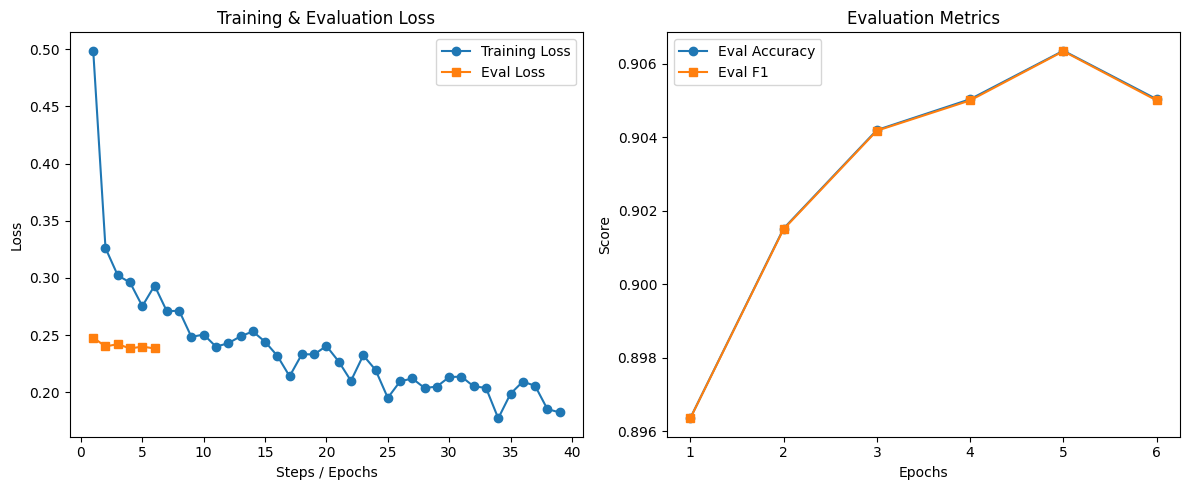

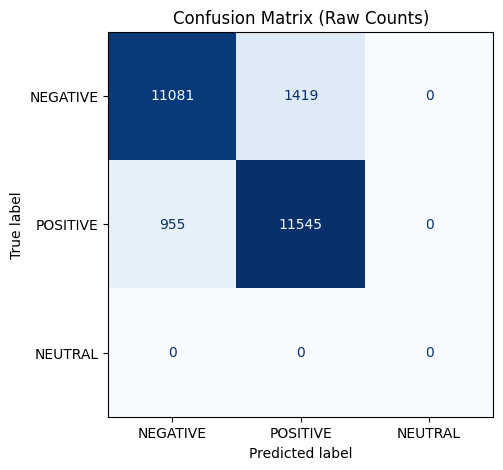

/tmp/ipython-input-4014963547.py:53: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]


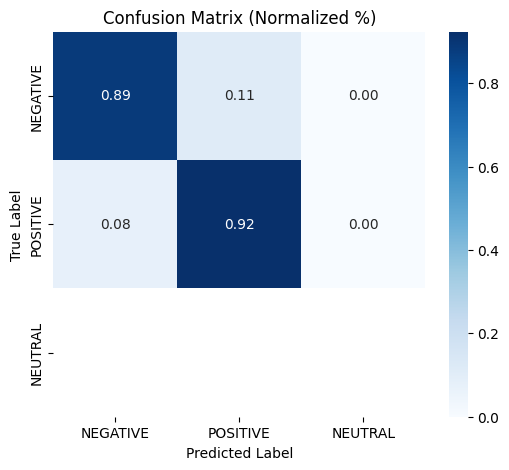

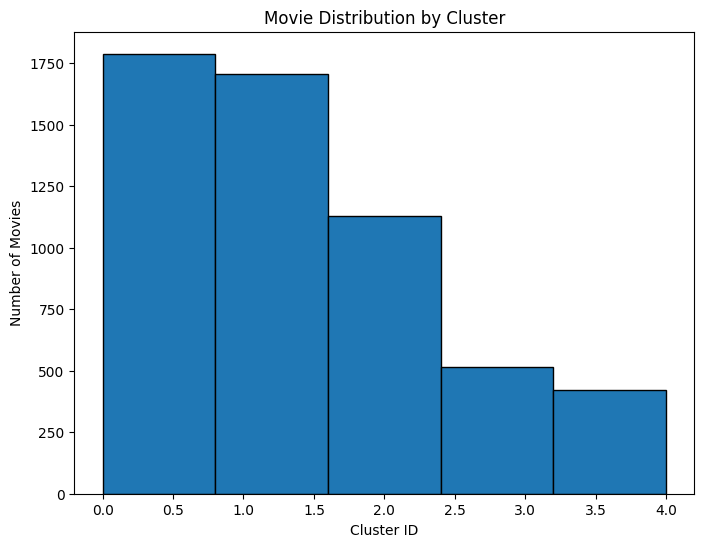

In [10]:
# =============================================
# 7) Visualization / Plots
# =============================================
# ---- Training Loss & Metrics ----
training_logs = trainer.state.log_history

train_loss = [log["loss"] for log in training_logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in training_logs if "eval_loss" in log]
eval_accuracy = [log["eval_accuracy"] for log in training_logs if "eval_accuracy" in log]
eval_f1 = [log["eval_f1"] for log in training_logs if "eval_f1" in log]
steps = list(range(1, len(train_loss) + 1))

plt.figure(figsize=(12, 5))

# Training & Evaluation Loss
plt.subplot(1, 2, 1)
plt.plot(steps, train_loss, label="Training Loss", marker="o")
if eval_loss:
    plt.plot(range(1, len(eval_loss) + 1), eval_loss, label="Eval Loss", marker="s")
plt.xlabel("Steps / Epochs")
plt.ylabel("Loss")
plt.title("Training & Evaluation Loss")
plt.legend()

# Accuracy & F1
plt.subplot(1, 2, 2)
if eval_accuracy:
    plt.plot(range(1, len(eval_accuracy) + 1), eval_accuracy, label="Eval Accuracy", marker="o")
if eval_f1:
    plt.plot(range(1, len(eval_f1) + 1), eval_f1, label="Eval F1", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.title("Evaluation Metrics")
plt.legend()

plt.tight_layout()
plt.show()

# ---- Confusion Matrix ----
preds_output = trainer.predict(eval_enc)
y_true = preds_output.label_ids
y_pred = preds_output.predictions.argmax(axis=-1)

cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NEGATIVE", "POSITIVE", "NEUTRAL"])

plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format="d", ax=plt.gca(), colorbar=False)
plt.title("Confusion Matrix (Raw Counts)")
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6, 5))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["NEGATIVE", "POSITIVE", "NEUTRAL"],
            yticklabels=["NEGATIVE", "POSITIVE", "NEUTRAL"])
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix (Normalized %)")
plt.show()

# ---- Clustering Results ----
plt.figure(figsize=(8, 6))
plt.hist(df_movies["Cluster"], bins=len(df_movies["Cluster"].unique()), edgecolor="black")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Movies")
plt.title("Movie Distribution by Cluster")
plt.show()

In [11]:
import pandas as pd

def check_text_columns(csv_path):
    """
    Check if the dataset contains any column that looks like a description/overview.
    """
    df = pd.read_csv(csv_path)
    text_like = []

    # Look for likely text columns
    for col in df.columns:
        # Check if column is object/string and has long average length
        if df[col].dtype == "object":
            avg_len = df[col].dropna().astype(str).map(len).mean()
            if avg_len > 30:  # heuristic: long enough to be a description
                text_like.append((col, avg_len))

    if text_like:
        print("✅ Found possible text columns for transformer embeddings:")
        for col, avg_len in text_like:
            print(f" - {col} (avg length: {avg_len:.1f})")
    else:
        print("⚠️ No long text columns found. You may only have metadata (title, genre, runtime, etc.).")
        print("In that case, we can embed: movie_title + genre fields.")

    return df.head()


In [12]:
movies_csv = "/content/imdb_data.csv"
check_text_columns(movies_csv)

✅ Found possible text columns for transformer embeddings:
 - Actors (avg length: 58.4)


,Movie_Title,Year,Director,Actors,Rating,Runtime(Mins),Censor,Total_Gross,main_genre,side_genre
0,Kantara,2022,Rishab Shetty,"Rishab Shetty, Sapthami Gowda, Kishore Kumar G...",9.3,148,UA,Gross Unkown,Action,"Adventure, Drama"
1,The Dark Knight,2008,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",9.0,152,UA,$534.86M,Action,"Crime, Drama"
2,The Lord of the Rings: The Return of the King,2003,Peter Jackson,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or...",9.0,201,U,$377.85M,Action,"Adventure, Drama"
3,Inception,2010,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",8.8,148,UA,$292.58M,Action,"Adventure, Sci-Fi"
4,The Lord of the Rings: The Two Towers,2002,Peter Jackson,"Elijah Wood, Ian McKellen, Viggo Mortensen, Or...",8.8,179,UA,$342.55M,Action,"Adventure, Drama"
